In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-07-22 05:49:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.67.240, 2404:6800:4007:805::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.67.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.08s   

2020-07-22 05:49:15 (920 KB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



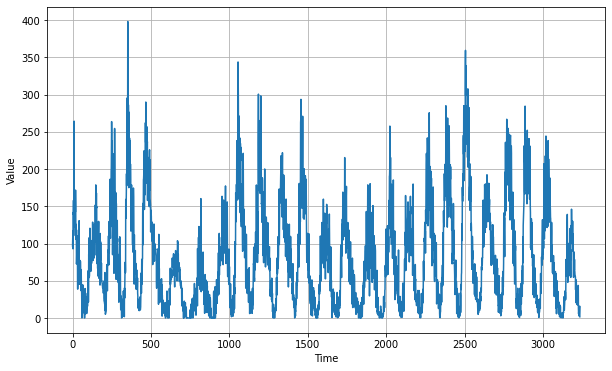

In [5]:
import csv
sunspots = []
time_step = []

with open('/tmp/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))
        
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forcast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forcast = model.predict(ds)
    return forcast

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = 'causal', activation = 'relu', input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'relu'),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber(), metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 0s 35ms/step - loss: 74.1868 - mae: 74.6764 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 73.5025 - mae: 73.9921 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 72.4542 - mae: 72.9441 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 71.1097 - mae: 71.6002 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 69.4577 - mae: 69.9485 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 67.4079 - mae: 67.8991 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 64.9158 - mae: 65.4071 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 62.0122 - mae: 62.5035 - l

12/12 [==============================] - 0s 11ms/step - loss: 22.2217 - mae: 22.7115 - lr: 3.1623e-05
Epoch 72/100
12/12 [==============================] - 0s 11ms/step - loss: 19.9089 - mae: 20.3993 - lr: 3.5481e-05
Epoch 73/100
12/12 [==============================] - 0s 11ms/step - loss: 21.1566 - mae: 21.6461 - lr: 3.9811e-05
Epoch 74/100
12/12 [==============================] - 0s 15ms/step - loss: 19.9028 - mae: 20.3924 - lr: 4.4668e-05
Epoch 75/100
12/12 [==============================] - 0s 24ms/step - loss: 20.4816 - mae: 20.9708 - lr: 5.0119e-05
Epoch 76/100
12/12 [==============================] - 0s 12ms/step - loss: 19.7167 - mae: 20.2063 - lr: 5.6234e-05
Epoch 77/100
12/12 [==============================] - 0s 11ms/step - loss: 22.8620 - mae: 23.3515 - lr: 6.3096e-05
Epoch 78/100
12/12 [==============================] - 0s 13ms/step - loss: 21.5054 - mae: 21.9947 - lr: 7.0795e-05
Epoch 79/100
12/12 [==============================] - 0s 13ms/step - loss: 24.1024 - mae: 24.

(1e-08, 0.0001, 0.0, 60.0)

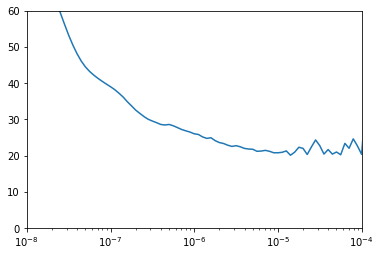

In [17]:
plt.semilogx(history.history['lr'], history.history['mae'])
plt.axis([1e-8, 1e-4, 0, 60])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer_size = shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 0s 6ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 0s 6ms/step - loss: 25.7615 - mae: 26.2559
Epoch 3/500
30/30 [==============================] - 0s 7ms/step - loss: 22.0742 - mae: 22.5679
Epoch 4/500
30/30 [==============================] - 0s 7ms/step - loss: 20.4516 - mae: 20.9443
Epoch 5/500
30/30 [==============================] - 0s 7ms/step - loss: 19.7430 - mae: 20.2354
Epoch 6/500
30/30 [==============================] - 0s 6ms/step - loss: 19.3672 - mae: 19.8592
Epoch 7/500
30/30 [==============================] - 0s 6ms/step - loss: 18.5855 - mae: 19.0774
Epoch 8/500
30/30 [==============================] - 0s 6ms/step - loss: 18.2070 - mae: 18.6987
Epoch 9/500
30/30 [==============================] - 0s 6ms/step - loss: 18.1086 - mae: 18.6003
Epoch 10/500
30/30 [==============================] - 0s 6ms/step - loss: 20.1807 - mae: 20.6727
Epoch 11/500
30/30 [===================

30/30 [==============================] - 0s 7ms/step - loss: 16.3983 - mae: 16.8868
Epoch 86/500
30/30 [==============================] - 0s 8ms/step - loss: 16.7548 - mae: 17.2436
Epoch 87/500
30/30 [==============================] - 0s 5ms/step - loss: 16.5129 - mae: 17.0019
Epoch 88/500
30/30 [==============================] - 0s 6ms/step - loss: 16.4801 - mae: 16.9687
Epoch 89/500
30/30 [==============================] - 0s 6ms/step - loss: 16.3274 - mae: 16.8158
Epoch 90/500
30/30 [==============================] - 0s 8ms/step - loss: 16.3763 - mae: 16.8648
Epoch 91/500
30/30 [==============================] - 0s 5ms/step - loss: 16.4491 - mae: 16.9380
Epoch 92/500
30/30 [==============================] - 0s 5ms/step - loss: 16.4421 - mae: 16.9307
Epoch 93/500
30/30 [==============================] - 0s 5ms/step - loss: 16.4235 - mae: 16.9126
Epoch 94/500
30/30 [==============================] - 0s 6ms/step - loss: 16.6119 - mae: 17.1003
Epoch 95/500
30/30 [=======================

30/30 [==============================] - 0s 9ms/step - loss: 16.1351 - mae: 16.6242
Epoch 169/500
30/30 [==============================] - 0s 10ms/step - loss: 15.8696 - mae: 16.3578
Epoch 170/500
30/30 [==============================] - 0s 5ms/step - loss: 15.8929 - mae: 16.3814
Epoch 171/500
30/30 [==============================] - 0s 6ms/step - loss: 15.8495 - mae: 16.3380
Epoch 172/500
30/30 [==============================] - 0s 7ms/step - loss: 15.8760 - mae: 16.3647
Epoch 173/500
30/30 [==============================] - 0s 7ms/step - loss: 15.8769 - mae: 16.3652
Epoch 174/500
30/30 [==============================] - 0s 6ms/step - loss: 16.0544 - mae: 16.5434
Epoch 175/500
30/30 [==============================] - 0s 7ms/step - loss: 15.9144 - mae: 16.4031
Epoch 176/500
30/30 [==============================] - 0s 6ms/step - loss: 15.8356 - mae: 16.3239
Epoch 177/500
30/30 [==============================] - 0s 7ms/step - loss: 15.8850 - mae: 16.3737
Epoch 178/500
30/30 [============

30/30 [==============================] - 0s 6ms/step - loss: 15.5173 - mae: 16.0049
Epoch 252/500
30/30 [==============================] - 0s 6ms/step - loss: 15.5656 - mae: 16.0531
Epoch 253/500
30/30 [==============================] - 0s 7ms/step - loss: 15.5166 - mae: 16.0041
Epoch 254/500
30/30 [==============================] - 0s 6ms/step - loss: 15.5010 - mae: 15.9884
Epoch 255/500
30/30 [==============================] - 0s 6ms/step - loss: 15.5183 - mae: 16.0059
Epoch 256/500
30/30 [==============================] - 0s 6ms/step - loss: 15.5713 - mae: 16.0590
Epoch 257/500
30/30 [==============================] - 0s 6ms/step - loss: 15.5201 - mae: 16.0076
Epoch 258/500
30/30 [==============================] - 0s 7ms/step - loss: 15.4661 - mae: 15.9535
Epoch 259/500
30/30 [==============================] - 0s 7ms/step - loss: 15.4875 - mae: 15.9752
Epoch 260/500
30/30 [==============================] - 0s 7ms/step - loss: 15.6570 - mae: 16.1455
Epoch 261/500
30/30 [=============

30/30 [==============================] - 0s 7ms/step - loss: 15.0971 - mae: 15.5837
Epoch 335/500
30/30 [==============================] - 0s 7ms/step - loss: 15.1047 - mae: 15.5908
Epoch 336/500
30/30 [==============================] - 0s 7ms/step - loss: 15.2116 - mae: 15.6986
Epoch 337/500
30/30 [==============================] - 0s 6ms/step - loss: 15.2303 - mae: 15.7176
Epoch 338/500
30/30 [==============================] - 0s 6ms/step - loss: 15.1765 - mae: 15.6631
Epoch 339/500
30/30 [==============================] - 0s 6ms/step - loss: 15.1688 - mae: 15.6557
Epoch 340/500
30/30 [==============================] - 0s 6ms/step - loss: 15.2513 - mae: 15.7386
Epoch 341/500
30/30 [==============================] - 0s 7ms/step - loss: 15.1740 - mae: 15.6611
Epoch 342/500
30/30 [==============================] - 0s 7ms/step - loss: 15.1641 - mae: 15.6517
Epoch 343/500
30/30 [==============================] - 0s 7ms/step - loss: 15.1582 - mae: 15.6451
Epoch 344/500
30/30 [=============

30/30 [==============================] - 0s 9ms/step - loss: 14.8165 - mae: 15.3028
Epoch 418/500
30/30 [==============================] - 0s 6ms/step - loss: 14.9872 - mae: 15.4736
Epoch 419/500
30/30 [==============================] - 0s 6ms/step - loss: 14.8042 - mae: 15.2900
Epoch 420/500
30/30 [==============================] - 0s 7ms/step - loss: 14.8990 - mae: 15.3854
Epoch 421/500
30/30 [==============================] - 0s 8ms/step - loss: 14.8748 - mae: 15.3612
Epoch 422/500
30/30 [==============================] - 0s 8ms/step - loss: 14.9494 - mae: 15.4353
Epoch 423/500
30/30 [==============================] - 0s 6ms/step - loss: 15.4065 - mae: 15.8936
Epoch 424/500
30/30 [==============================] - 0s 5ms/step - loss: 14.8916 - mae: 15.3782
Epoch 425/500
30/30 [==============================] - 0s 6ms/step - loss: 14.7329 - mae: 15.2186
Epoch 426/500
30/30 [==============================] - 0s 5ms/step - loss: 14.8290 - mae: 15.3146
Epoch 427/500
30/30 [=============

30/30 [==============================] - 0s 6ms/step - loss: 14.5672 - mae: 15.0529


In [20]:
rnn_forcast = model_forcast(model, series[...,np.newaxis], window_size)
rnn_forcast = rnn_forcast[split_time - window_size:-1, -1, 0]

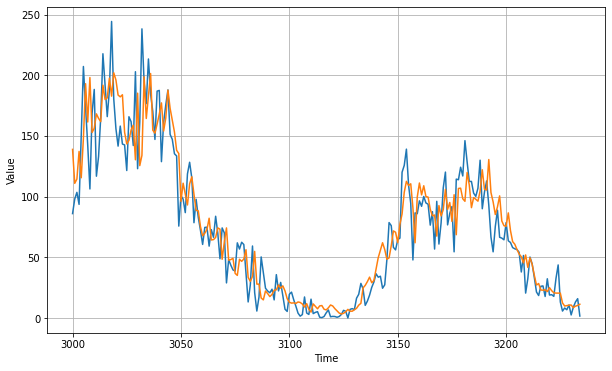

In [21]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forcast)

In [22]:
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forcast).numpy())

15.583575


<Figure size 432x288 with 0 Axes>

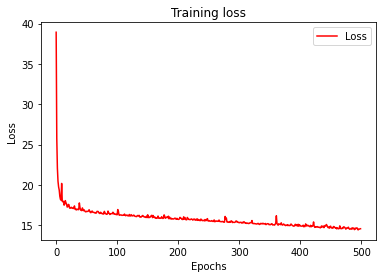

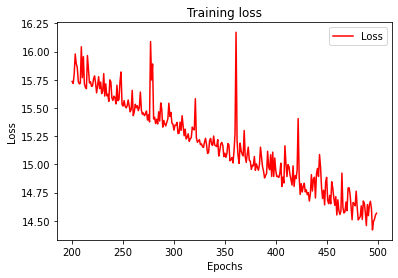

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [26]:
print(rnn_forcast)

[138.90445   110.91533   114.49873   137.22012   115.52785   148.03333
 193.0083    161.446     198.07605   152.85864   156.29082   168.16194
 164.4234    161.77551   191.80074   179.9812    181.33553   197.59715
 182.76625   201.99268   196.10197   183.65266   182.19173   183.90074
 153.00758   143.3837    146.30925   154.89085   158.85165   130.33536
 185.20113   125.51524   133.99683   198.67735   164.365     183.28458
 201.38525   154.73009   152.26851   159.74753   167.99254   177.19937
 154.02193   164.77322   187.71436   172.69012   162.79433   153.23
 138.18013   135.44133    96.11957   111.03709   102.04501    93.11054
 110.49109   116.352585  101.950386   88.70936    88.22323    75.28941
  67.68729    69.84295    72.99071    82.17963    64.252396   64.565506
  66.36412    74.20855    73.1832     48.358353   62.498783   74.19648
  47.655983   48.087345   49.17461    36.73122    35.091476   48.34843
  46.658714   48.575203   56.23182    33.392025   30.184927   34.274326
  54.85